In [1]:
from pathlib import Path
import time
from datetime import datetime

In [2]:
import openeo
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import xarray as xr
import numpy as np
import pandas as pd
from IPython.display import Image, display

# EFAST

The [Efficient Fusion Algorithm Across Spatio-Temporal Scales (EFAST)](https://doi.org/10.3390/rs16111833) \[1\] is a method to create time-series with a fine resolution in space and time from a fine spatial but coarse temporal resolution
source (Sentinel-2) and a coarse temporal but fine spatial resolution source (Sentinel-3).

In comparison to other methods (e.g. STARFM), EFAST aims to achieve results outperforming single-source Sentinel-2
time-series interpolation by exploiting change information from Sentinel-3 with minimal computational cost,
assuming homogeneous temporal dynamics.
EFAST was originally designed to accurately capture seasonal vegetation changes in homogeneous areas like range lands
which present long temporal gaps in Sentinel-2 time series during the rainy season.


DHI has published a [Python implementation of the algorithm](https://github.com/DHI-GRAS/efast).
In the context of the ESA funded [APEx initiative](https://apex.esa.int/), the algorithm has been ported to OpenEO
by [Brockmann Consult GmbH](https://www.brockmann-consult.de/) and is implemented as a OpenEO [process graph](https://github.com/bcdev/efast-process-graph/).


\[1\]: Senty, Paul, Radoslaw Guzinski, Kenneth Grogan, et al. “Fast Fusion of Sentinel-2 and Sentinel-3 Time Series over Rangelands.” Remote Sensing 16, no. 11 (2024): 1833. https://doi.org/10.3390/rs16111833

In [3]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [4]:
PROCESS_GRAPH_URL = "https://raw.githubusercontent.com/bcdev/efast-process-graph/refs/heads/main/process_graph.json"

In [5]:
SKIP_EXECUTION = False # If True do not rerun process graph / download (expects that the output directory is already filled)
WAIT_FOR_COMPLETION = True # Set to False to not block after submitting openeo jobs

## Parameters

EFAST transforms the two input time series of Sentinel-2 and Sentinel-3 observations into a target time series.
The input time series are defined by the familiar `temporal_extent` parameter and the availability of data for each sensor.
The target time series is defined by a separate parameter `temporal_extent_target`, together with the target interval `interval_days`.
`temporal_extent_target` should cover a shorter interval, fully contained within `temporal_extent`, because EFAST considers temporal context both before and after the target observation when computing its result, with a standard deviation of `temporal_score_stddev` (20 days by default). This allows for some temporal context for the first and last time step of the target time series. This parameter is optional. If it is not provided, the entire temporal extent of the input (`temporal_extent`) is reused to define the target time series.

EFAST uses bands with closely aligned central wavelengths to interpolate between Sentinel-2 observations. The process graph takes the parameters
`s2_data_bands` and `s3_data_bands` to define which bands should be computed. Users must take care to specify band names that match in central wavelength and to specify bands of similar wavelength in the same position in the list.

For example, to compute a RGB image, we can use the blue, green, and red bands of both the Sentinel-2 and Sentinel-3 collections:

- `s2_data_bands=["B02", "B03", "B04"]` with central wavelengths 490nm (blue), 560nm (green) and 665nm (red)
- `s3_data_bands=["Syn_Oa04_reflectance", "Syn_Oa06_reflectance", "Syn_Oa08_reflectance", "CLOUD_flags"]` with central wavelengths 490nm, 560nm and 665nm

And to compute the NDVI, we can use

- `s2_data_bands=["B04","B8A"]` with central wavelengths 665nm (red) and 865nm (NIR)
- `s3_data_bands=["Syn_Oa08_reflectance", "Syn_Oa17_reflectance", "CLOUD_flags"]`, with central wavelengths 490nm and 865nm.

The EFAST UDP actually provides a parameter, `output_ndvi`, to return the NDVI as the single output band instead of the band values.
When setting this option to True, make sure that the correct bands are included, otherwise the process will fail.

In total, we set the following parameters:

- `s2_data_bands` bands of the `SENTINEL2_L2A` collection. Make sure to align bands with `s3_data_bands`. This **must not include** `SCL`.
- `s3_data_bands` bands of the `SENTINEL3_SYN_L2_SYN` collection. Make sure to align the bands with `s2_data_bands`. This **must include** `CLOUD_flags`.
- `temporal_extent` temporal extent of the *inputs*
- `temporal_extent_target` (optional, default `temporal_extent`) temporal extent of the *output*. Should be fully covered by `temporal_extent`.
- `spatial_extent` the spatial extent of inputs and outputs.
- `interval_days` interval of the output time series (days)
- `temporal_score_stddev` smoothing parameter, controlling the amount of temporal context for the fusion
- `output_ndvi` (optional, default `False`) whether to output NDVI instead of bands. If set, `s2_data_bands` must be `["B04","B8A"]` and `s3_data_bands` must be `["Syn_Oa08_reflectance", "Syn_Oa17_reflectance", "CLOUD_flags"]`

For a first example, we set the RGB bands:

In [6]:
s2_data_bands = ["B02", "B03", "B04"]
s3_data_bands=["Syn_Oa04_reflectance", "Syn_Oa06_reflectance", "Syn_Oa08_reflectance", "CLOUD_flags"]
fused_band_names = [] # optional
temporal_extent = ["2023-09-01", "2023-10-15"]
temporal_extent_target = ["2023-09-03", "2023-10-13"]
spatial_extent={
    "west": -15.9,
    "south": 15.67,
    "east": -15.3,
    "north": 16.27,
}
interval_days = 4
temporal_score_stddev = 20

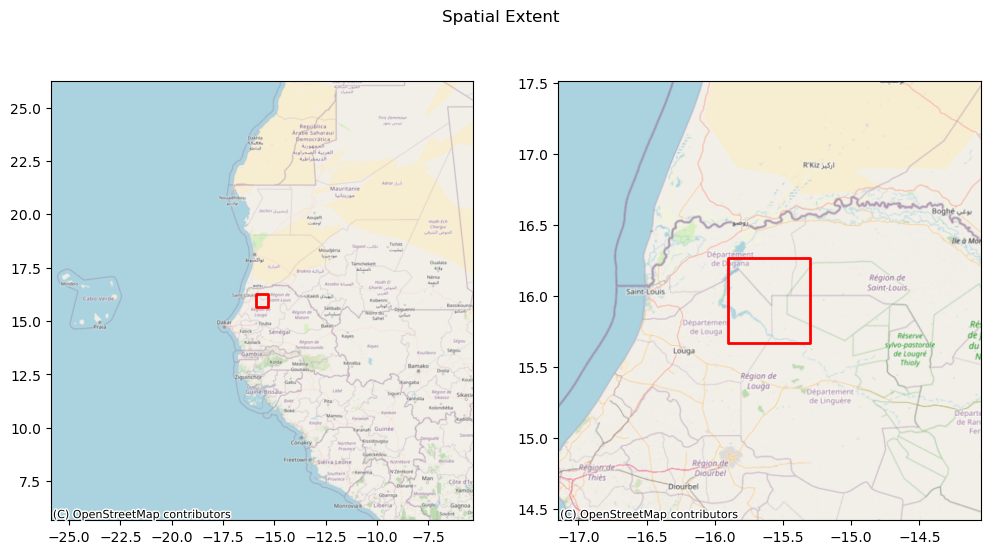

In [7]:
w = spatial_extent["west"]
e = spatial_extent["east"]
s = spatial_extent["south"]
n = spatial_extent["north"]

polygon = Polygon([(w, s), (e, s), (e, n), (w, n)])
gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
gdf.plot(edgecolor="red", facecolor="none", linewidth=2, ax=axs[0])
gdf.plot(edgecolor="red", facecolor="none", linewidth=2, ax=axs[1])
large_context = 10
small_context = 1.25
axs[0].set_xlim(w - large_context, e + large_context)
axs[0].set_ylim(s - large_context, n + large_context)
axs[1].set_xlim(w - small_context, e + small_context)
axs[1].set_ylim(s - small_context, n + small_context)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf.crs)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf.crs);
fig.suptitle("Spatial Extent");

## Defining the process graph

EFAST is defined as a UDP, so we can run it using `datacube_from_process`, providing the name (`efast`) and a URL to the process graph JSON as `namespace`. All the other parameters belong to the EFAST UDP, as described above.

In [8]:
cube = connection.datacube_from_process(
    "efast",
    namespace=PROCESS_GRAPH_URL,
    s2_data_bands=s2_data_bands,
    s3_data_bands=s3_data_bands,
    temporal_extent=temporal_extent,
    temporal_extent_target=temporal_extent_target,
    spatial_extent=spatial_extent,
    interval_days=interval_days,
    temporal_score_stddev=temporal_score_stddev,

)
print(cube.to_json())

{
  "process_graph": {
    "efast1": {
      "process_id": "efast",
      "arguments": {
        "interval_days": 4,
        "s2_data_bands": [
          "B02",
          "B03",
          "B04"
        ],
        "s3_data_bands": [
          "Syn_Oa04_reflectance",
          "Syn_Oa06_reflectance",
          "Syn_Oa08_reflectance",
          "CLOUD_flags"
        ],
        "spatial_extent": {
          "west": -15.9,
          "south": 15.67,
          "east": -15.3,
          "north": 16.27
        },
        "temporal_extent": [
          "2023-09-01",
          "2023-10-15"
        ],
        "temporal_extent_target": [
          "2023-09-03",
          "2023-10-13"
        ],
        "temporal_score_stddev": 20
      },
      "namespace": "https://raw.githubusercontent.com/bcdev/efast-process-graph/refs/heads/main/process_graph.json",
      "result": true
    }
  }
}


As a second example, we define a cube that computes the NDVI directly. Note that we set the bands to the red and nir bands of each collection.

In [9]:
ndvi_cube = connection.datacube_from_process(
    "efast",
    namespace=PROCESS_GRAPH_URL,
    s2_data_bands=["B04","B8A"],
    s3_data_bands=["Syn_Oa08_reflectance", "Syn_Oa17_reflectance", "CLOUD_flags"],
    temporal_extent=temporal_extent,
    temporal_extent_target=temporal_extent_target,
    spatial_extent=spatial_extent,
    interval_days=interval_days,
    temporal_score_stddev=temporal_score_stddev,
    output_ndvi=True,
)

## Execute both parametrized process graphs

Now, we just start the jobs, wait until they are complete, and download the results.
Because EFAST fundamentally produces time series, `netcdf` is a good file format to choose. It is possible to generate `geotiff` output as well,
but by default, each time step of the output will have its own file. In that case, we would need to use `download_files` instead of `download_file`.

In [10]:
out_path = Path("outputs")
out_path.mkdir(exist_ok=True)

ndvi_cube_path = out_path / "efast_ndvi.nc"
bands_cube_path = out_path / "efast_with_bands.nc"

In [11]:
%%time
def execute_jobs(bands_job, ndvi_job, wait_for_completion=True):
    bands_job.start()
    ndvi_job.start()

    if not wait_for_completion:
        return

    bands_status, ndvi_status = bands_job.status(), ndvi_job.status()
    incomplete_statuses = ["created", "queued", "running"]
    poll_interval = 40 # seconds
    
    while bands_status in incomplete_statuses or ndvi_status in incomplete_statuses:
        time_str = f"[{datetime.now().strftime('%Y-%m-%d | %H:%M:%S')}]"
        print(f"{time_str}\tbands: {bands_status}\tndvi: {ndvi_status}")
        time.sleep(poll_interval)
        bands_status, ndvi_status = bands_job.status(), ndvi_job.status()
    print(f"bands: {bands_status}\tndvi: {ndvi_status}")

if not SKIP_EXECUTION:
    ndvi_job = ndvi_cube.create_job(title="EFAST with NDVI", out_format="netcdf")
    bands_job = cube.create_job(title="EFAST with bands", out_format="netcdf")
    print(f"bands job id: {bands_job.job_id}")
    print(f"ndvi job id: {ndvi_job.job_id}")
    execute_jobs(bands_job, ndvi_job, WAIT_FOR_COMPLETION)
    if WAIT_FOR_COMPLETION:
        bands_job.get_results().download_file(bands_cube_path)
        ndvi_job.get_results().download_file(ndvi_cube_path)

bands job id: j-2602021052494ec6b1e7b52d3efde745
ndvi job id: j-260202105248440099f493a4c9503336
[2026-02-02 | 11:53:22]	bands: running	ndvi: queued
[2026-02-02 | 11:54:02]	bands: running	ndvi: queued
[2026-02-02 | 11:54:42]	bands: running	ndvi: running
[2026-02-02 | 11:55:23]	bands: running	ndvi: running
[2026-02-02 | 11:56:03]	bands: running	ndvi: running
[2026-02-02 | 11:56:43]	bands: running	ndvi: running
[2026-02-02 | 11:57:23]	bands: running	ndvi: running
[2026-02-02 | 11:58:04]	bands: running	ndvi: running
[2026-02-02 | 11:58:44]	bands: running	ndvi: running
[2026-02-02 | 11:59:24]	bands: running	ndvi: running
[2026-02-02 | 12:00:04]	bands: running	ndvi: running
[2026-02-02 | 12:00:45]	bands: running	ndvi: running
[2026-02-02 | 12:01:25]	bands: running	ndvi: running
[2026-02-02 | 12:02:05]	bands: running	ndvi: running
[2026-02-02 | 12:02:46]	bands: running	ndvi: running
[2026-02-02 | 12:03:32]	bands: running	ndvi: running
[2026-02-02 | 12:04:12]	bands: running	ndvi: running
[202

## Visualize results

We can visualize EFAST results by generating time series animations for the NDVI and RGB results that we computed.
Because the files are large, we pass `chunks="auto"` to `xarray.open_dataset`. This makes sure that xarray uses dask to process our files
by chunk and does not load the entire dataset into memory at once.

In [14]:
animation_base_path = Path("img")
animation_base_path.mkdir(exist_ok=True)

bands_animation_path = animation_base_path / "bands.gif"
ndvi_animation_path = animation_base_path / "ndvi.gif"

### Bands

In [12]:
bands_ds = xr.open_dataset(bands_cube_path, chunks="auto")
fig, ax = plt.subplots()
band_names = ["B04", "B03", "B02"]
bands_da = xr.concat(
    [bands_ds[b] for b in band_names], dim="band"
).coarsen(x=16, y=16, boundary="trim").mean()
p = bands_da.isel(t=0).plot.imshow(ax=ax)

def update(frame):
    data = bands_da.isel(t=frame).clip(0,1).transpose("y", "x", "band").values
    p.set_array(data)
    timestamp = pd.to_datetime(bands_da.t[frame].values)
    label = timestamp.strftime("%Y-%m-%d")
    ax.set_title(f"RGB @ {label}", fontsize=24)
    return (p,)

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(bands_da.t), interval=600, blit=True)
ani.save(bands_animation_path, writer="pillow")
plt.close(fig)
# HTML(ani.to_jshtml()) # interactive animation

<img src="img/bands.gif"> 

### NDVI

In [13]:
ndvi_da = xr.open_dataset(ndvi_cube_path, chunks="auto")["ndvi"]
fig, ax = plt.subplots()
imshow_args = dict(cmap="RdYlGn", vmin=-1, vmax=1)

p = ndvi_da.isel(t=0).plot.imshow(ax=ax, **imshow_args)

def update(frame):
    data = ndvi_da.isel(t=frame).values
    p.set_array(data)
    timestamp = pd.to_datetime(ndvi_da.t[frame].values)
    label = timestamp.strftime("NDVI @ %Y-%m-%d")
    ax.set_title(label, fontsize=20)
    return (p,)

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(ndvi_da.t), interval=600, blit=True)
plt.close(fig)
ani.save(ndvi_animation_path, writer="pillow")
plt.close(fig)
# HTML(ani.to_jshtml()) # interactive animation

<img src="img/ndvi.gif"> 